# 30分钟吃掉wandb可视化模型分析

wandb是"我爱你，大baby"首字母的缩写。

顾名思义，她是炼丹师的大宝贝，是炼丹师最爱的炼丹伴侣。


just kidding, 开个玩笑！

wandb全称weights&bias，是一款类似TensorBoard

的机器学习可视化分析工具。

相比TensorBoard，wandb具有如下主要优势：

* 日志上传云端永久存储，便于分享不怕丢失。

* 可以存管代码,数据集和模型的版本，随时复现。(wandb.Artifact)

* 可以使用交互式表格进行case分析(wandb.Table)

* 可以自动化模型调参。(wandb.sweep)



官方文档： https://docs.wandb.ai/ 


![](https://tva1.sinaimg.cn/large/008vOhrAgy1hakba64ol9j31920mcjud.jpg)


总体来说，wandb目前的核心功能有以下4个：

1，实验跟踪：experiment tracking （wandb.log）

2，版本管理：version management (wandb.log_artifact, wandb.save)

3，case分析：case visualization (wandb.Table, wandb.Image)

4，超参调优：model optimization (wandb.sweep)

本文我们主要介绍 前3个能力，超参调优的介绍在另一篇文章。



## 〇，注册wandb

使用wandb可视化模型训练过程需要在  https://wandb.ai/ 注册账户，

并在个人settings页面获取 API keys。

In [1]:
#import os
#os.environ["WANDB_API_KEY"] = "xxxx"

import wandb
wandb.login()



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: skywalk3r. Use `wandb login --relogin` to force relogin


True

## 一，实验跟踪

wandb 提供了类似 TensorBoard的实验跟踪能力，主要包括：

* 模型配置超参数的记录

* 模型训练过程中loss，metric等各种指标的记录和可视化

* 图像的可视化(wandb.Image)

* 其他各种Media(wandb.Vedio, wandb.Audio, wandb.Html, 3D点云等)


In [2]:
import os,PIL 
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch 
from torch import nn 
import torchvision 
from torchvision import transforms
import datetime
import wandb 
from argparse import Namespace

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = Namespace(
    project_name = 'wandb_demo',
    
    batch_size = 512,
    
    hidden_layer_width = 64,
    dropout_p = 0.1,
    
    lr = 1e-4,
    optim_type = 'Adam',
    
    epochs = 15,
    ckpt_path = 'checkpoint.pt'
)

# stage1_optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, stage1_model.parameters()), \
#            Parameters["LEARNING_RATE"], [Parameters["BETA1"], Parameters["BETA2"]])

In [3]:
def create_dataloaders(config):
    transform = transforms.Compose([transforms.ToTensor()])
    ds_train = torchvision.datasets.MNIST(root="./mnist/",train=True,download=True,transform=transform)
    ds_val = torchvision.datasets.MNIST(root="./mnist/",train=False,download=True,transform=transform)

    ds_train_sub = torch.utils.data.Subset(ds_train, indices=range(0, len(ds_train), 5))
    dl_train =  torch.utils.data.DataLoader(ds_train_sub, batch_size=config.batch_size, shuffle=True,
                                            num_workers=2,drop_last=True)
    dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=config.batch_size, shuffle=False, 
                                          num_workers=2,drop_last=True)
    return dl_train,dl_val

In [4]:
def create_net(config):
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=config.hidden_layer_width,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2)) 
    net.add_module("conv2",nn.Conv2d(in_channels=config.hidden_layer_width,
                                     out_channels=config.hidden_layer_width,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = config.dropout_p))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(config.hidden_layer_width,config.hidden_layer_width))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(config.hidden_layer_width,10))
    net.to(device)
    return net 

In [5]:
def train_epoch(model,dl_train,optimizer):
    model.train()
    for step, batch in enumerate(dl_train):
        features,labels = batch
        features,labels = features.to(device),labels.to(device)

        preds = model(features)
        loss = nn.CrossEntropyLoss()(preds,labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    return model

In [6]:
def eval_epoch(model,dl_val):
    model.eval()
    accurate = 0
    num_elems = 0
    for batch in dl_val:
        features,labels = batch
        features,labels = features.to(device),labels.to(device)
        with torch.no_grad():
            preds = model(features)
        predictions = preds.argmax(dim=-1)
        accurate_preds =  (predictions==labels)
        num_elems += accurate_preds.shape[0]
        accurate += accurate_preds.long().sum()

    val_acc = accurate.item() / num_elems
    return val_acc
    

In [8]:
def train(config = config):
    dl_train, dl_val = create_dataloaders(config)
    model = create_net(config); 
    optimizer = torch.optim.__dict__[config.optim_type](params=model.parameters(), lr=config.lr)
    #======================================================================
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')  # 2023-03-08 19:07:52
    with wandb.init(project=config.project_name, config = config.__dict__, name = nowtime, save_code=True):
        model.run_id = wandb.run.id
        #======================================================================
        model.best_metric = -1.0
        for epoch in range(1,config.epochs+1):
            model = train_epoch(model,dl_train,optimizer)
            val_acc = eval_epoch(model,dl_val)
            if val_acc>model.best_metric:
                model.best_metric = val_acc
                torch.save(model.state_dict(),config.ckpt_path)   
            nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print(f"epoch【{epoch}】@{nowtime} --> val_acc= {100 * val_acc:.2f}%")
            #======================================================================
            wandb.log({'epoch':epoch, 'val_acc': val_acc, 'best_val_acc':model.best_metric})
            #======================================================================        
        #======================================================================
    #wandb.finish()
    #======================================================================
    return model   

In [ ]:
    # wandb.init(project=config.project_name, config = config.__dict__, name = nowtime, save_code=True)
    # wandb.log({'epoch':epoch, 'val_acc': val_acc, 'best_val_acc':model.best_metric})

In [9]:
model = train(config) ##3,2,1 点火🔥🔥

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



epoch【1】@2023-03-08 19:22:05 --> val_acc= 22.48%
epoch【2】@2023-03-08 19:22:07 --> val_acc= 44.72%
epoch【3】@2023-03-08 19:22:08 --> val_acc= 51.77%
epoch【4】@2023-03-08 19:22:09 --> val_acc= 63.90%
epoch【5】@2023-03-08 19:22:10 --> val_acc= 71.97%
epoch【6】@2023-03-08 19:22:11 --> val_acc= 81.78%
epoch【7】@2023-03-08 19:22:13 --> val_acc= 82.83%
epoch【8】@2023-03-08 19:22:14 --> val_acc= 86.36%
epoch【9】@2023-03-08 19:22:15 --> val_acc= 87.80%
epoch【10】@2023-03-08 19:22:16 --> val_acc= 88.73%
epoch【11】@2023-03-08 19:22:17 --> val_acc= 89.10%
epoch【12】@2023-03-08 19:22:19 --> val_acc= 90.42%
epoch【13】@2023-03-08 19:22:20 --> val_acc= 90.86%
epoch【14】@2023-03-08 19:22:21 --> val_acc= 91.27%
epoch【15】@2023-03-08 19:22:22 --> val_acc= 91.63%


best_val_acc,▁▃▄▅▆▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
val_acc,▁▃▄▅▆▇▇▇███████
best_val_acc,0.91632
epoch,15
val_acc,0.91632


## 二，版本管理

除了可以记录实验日志传递到 wandb 网站的云端服务器 并进行可视化分析。

wandb还能够将实验关联的数据集，代码和模型 保存到 wandb 服务器。

非常便于我们以后 或者其他人 对实验结果进行复现。

我们可以通过 wandb.log_artifact的方法来保存任务的关联的重要成果。

例如dataset, code，和 model，并进行版本管理。

**注：artifact翻译为"工件"，是指软件开发中产出的最终成果.** 


我们先使用run_id 恢复 run任务，以便继续记录。

In [10]:
#resume the run 
import wandb 

run = wandb.init(project='wandb_demo', id= model.run_id, resume='must')


In [14]:
# save dataset 
arti_dataset = wandb.Artifact('mnist', type='dataset')
arti_dataset.add_dir('mnist/')
wandb.log_artifact(arti_dataset)


wandb: Adding directory to artifact (./mnist)... Done. 0.1s


In [15]:
# save code 

arti_code = wandb.Artifact('ipynb', type='code')
arti_code.add_file('./30分钟吃掉wandb可视化模型分析.ipynb')
wandb.log_artifact(arti_code)


In [16]:
# save model

arti_model = wandb.Artifact('cnn', type='model')
arti_model.add_file(config.ckpt_path)
wandb.log_artifact(arti_model)


In [17]:
wandb.finish() #finish时会提交保存

best_val_acc,0.91632
epoch,15
val_acc,0.91632


## 三，Case分析

利用 wandb.Table 我们可以在 wandb的 dashboard 进行交互式可视化的 case分析。

In [18]:
#resume the run 
import wandb 
run = wandb.init(project=config.project_name, id= model.run_id, resume='must')


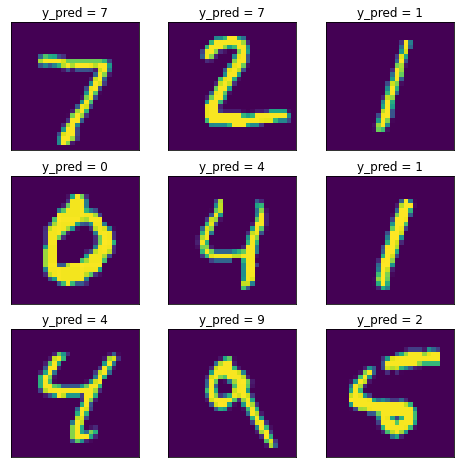

In [37]:
import matplotlib.pyplot as plt 

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="./mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="./mnist/",train=False,download=True,transform=transform)
    
# visual the  prediction
device = None
for p in model.parameters():
    device = p.device
    break

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_val[i]
    tensor = img.to(device)
    #print(img.shape)
    y_pred = torch.argmax(model(tensor[None,...])) 
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    #print(img)
    ax.imshow(img.numpy())
    ax.set_title("y_pred = %d"%y_pred)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()    

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]


In [21]:
# import matplotlib.pyplot as plt 
# import numpy as np

# img = np.random.rand(33, 33, 1)
# fig = plt.figure()
# ax = fig.add_subplot()
# ax.imshow(img)
# # ax.set_xticks(list(range(0, 34, 2)))
# ax.set_xticks([]) 
# ax.set_yticks([]) 
# #plt.imshow(img)

In [38]:
def data2fig(data):
    import matplotlib.pyplot as plt 
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(data)
    ax.set_xticks([])
    ax.set_yticks([]) 
    return fig

def fig2img(fig):
    import io,PIL
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    #print("hh")
    img = PIL.Image.open(buf)
    return img


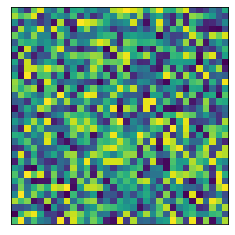

In [30]:
fig = data2fig(np.random.rand(33, 33, 1))

In [40]:
import wandb
from tqdm import tqdm 
good_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])
bad_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])


In [ ]:
# 找到50个good cases 和 50 个bad cases

plt.close()

with torch.no_grad():
    for i in tqdm(range(1000)):
        features,label = ds_val[i]
        tensor = features.to(device)
        y_pred = torch.argmax(model(tensor[None,...])) 
        
        # log badcase
        if y_pred!=label:
            if len(bad_cases.data)<50:
                data = features.permute(1,2,0).numpy()
                # numpy/ PIL /matplotlib FIgure 
                input_img = wandb.Image(fig2img(data2fig(data)))
                bad_cases.add_data(input_img,label,y_pred)
                
        # log goodcase
        else:
            if len(good_cases.data)<50:
                data = features.permute(1,2,0).numpy()
                input_img = wandb.Image(fig2img(data2fig(data)))
                good_cases.add_data(input_img,label,y_pred)
                

In [32]:
wandb.log({'good_cases':good_cases,'bad_cases':bad_cases})

In [33]:
wandb.finish()

best_val_acc,0.91632
epoch,15
val_acc,0.91632


然后就可以在 DashBoard中对Table 进行交互式的分析了，

包括常用的 sort, filter, group 等操作，妥妥的一个网页版的 Excel。 

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)